In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-prediction/heart.csv


# Setting Up


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from matplotlib import rcParams

from sklearn import model_selection
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings(action='ignore')

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Reading the data

In [3]:
df = pd.read_csv("../input/heart-failure-prediction/heart.csv")

-----------------------------------------------------------------
## Features
* **Age**: age of the patient [years]
* **Sex**: sex of the patient [M: Male, F: Female]
* **ChestPainType**: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* **RestingBP**: resting blood pressure [mm Hg]
* **Cholesterol**: serum cholesterol [mm/dl]
* **FastingBS**: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* **RestingECG**: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* **MaxHR**: maximum heart rate achieved [Numeric value between 60 and 202]
* **ExerciseAngina**: exercise-induced angina [Y: Yes, N: No]
* **Oldpeak**: oldpeak = ST [Numeric value measured in depression]
* **ST_Slope**: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* **HeartDisease**: output class [1: heart disease, 0: Normal]

# Exploring Data

In [4]:
df.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [7]:
df.corr()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
Age,1.000000,0.254399,-0.095282,0.198039,-0.382045,0.258612,0.282039
RestingBP,0.254399,1.000000,0.100893,0.070193,-0.112135,0.164803,0.107589
Cholesterol,-0.095282,0.100893,1.000000,-0.260974,0.235792,0.050148,-0.232741
FastingBS,0.198039,0.070193,-0.260974,1.000000,-0.131438,0.052698,0.267291
MaxHR,-0.382045,-0.112135,0.235792,-0.131438,1.000000,-0.160691,-0.400421
Oldpeak,0.258612,0.164803,0.050148,0.052698,-0.160691,1.000000,0.403951
HeartDisease,0.282039,0.107589,-0.232741,0.267291,-0.400421,0.403951,1.000000


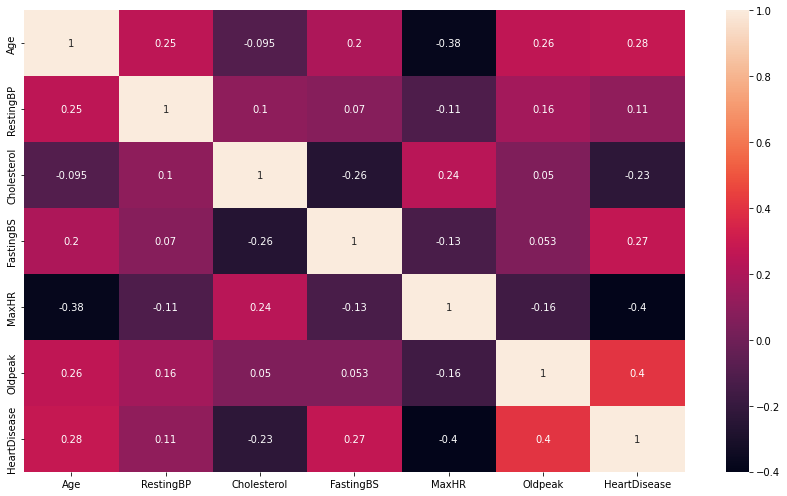

In [8]:
plt.figure(figsize=(12,7))
df.corr()
sns.heatmap(df.corr(),annot=True)
plt.tight_layout()

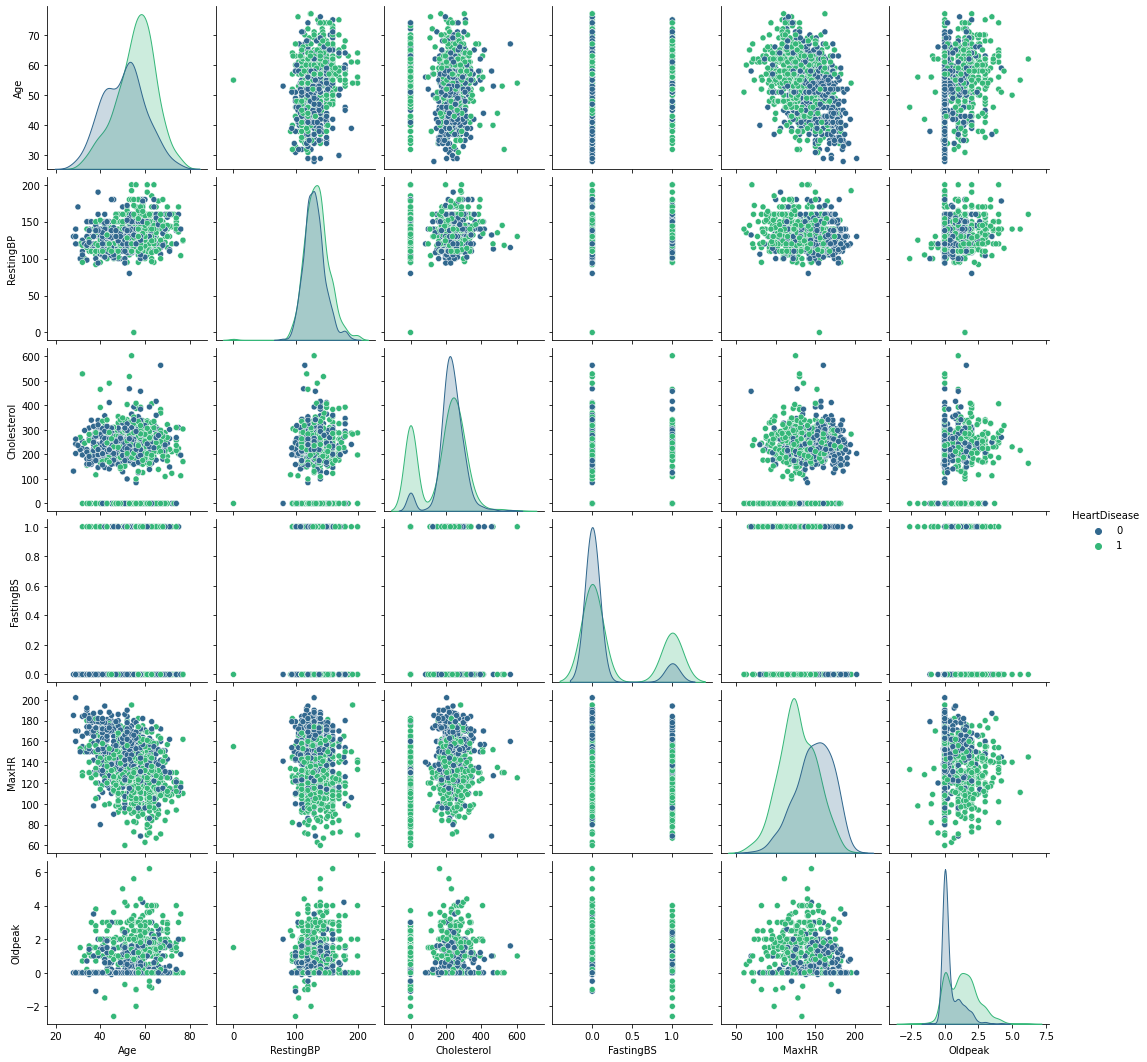

In [9]:
sns.pairplot(df,hue='HeartDisease',palette='viridis')

In [10]:
df['ChestPainType'].value_counts()

ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64

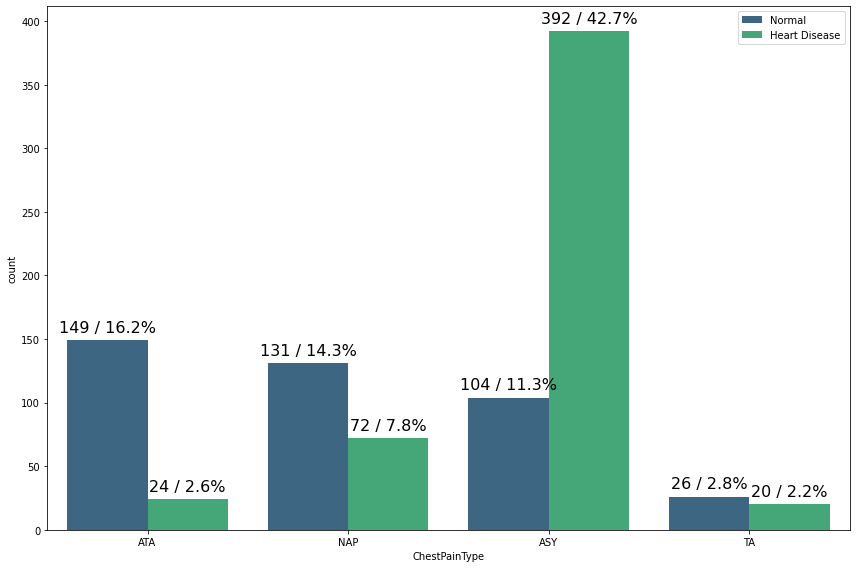

In [11]:
total_cnt = df['HeartDisease'].count()
plt.figure(figsize=(12,8))
ax = sns.countplot(data=df,x='ChestPainType',hue='HeartDisease',palette='viridis')
labels = ['Normal','Heart Disease']
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 10, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=16)
plt.legend(labels=labels)
plt.tight_layout()

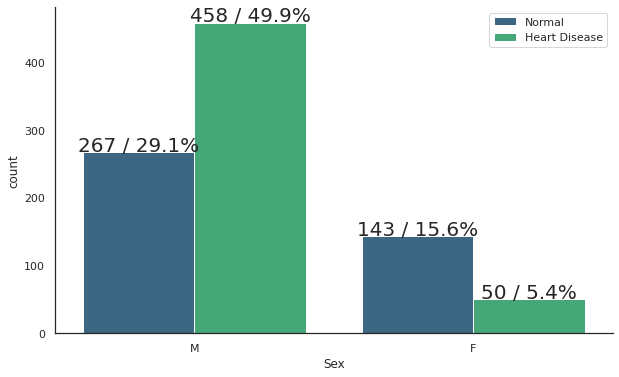

In [12]:
total_cnt = df['HeartDisease'].count()
plt.figure(figsize=(10,6))
sns.set(font_scale = 1)
sns.set_style("white")
ax = sns.countplot(data=df, x='Sex',hue='HeartDisease',palette='viridis')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 10, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=20)
plt.legend(labels=labels)
sns.despine()

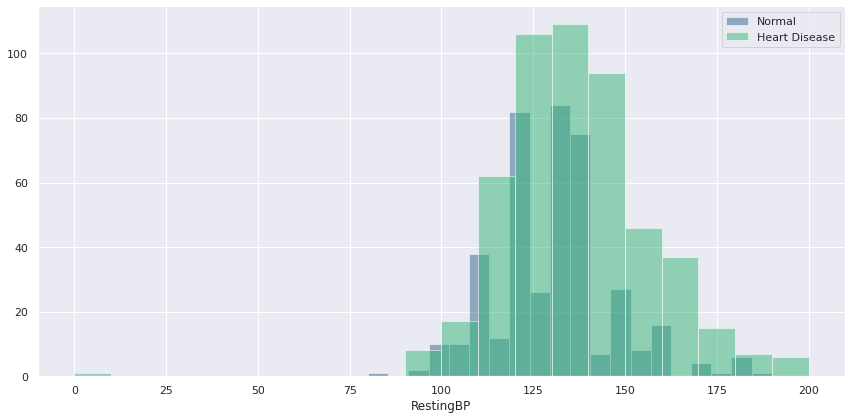

In [13]:
sns.set_style('darkgrid')
g = sns.FacetGrid(df,hue="HeartDisease",palette='viridis',height=6,aspect=2)
g = g.map(plt.hist,'RestingBP',bins=20,alpha=0.5)
plt.legend(labels=['Normal','Heart Disease'])

#sns.histplot(data=df,x='RestingBP',hue='HeartDisease',palette='viridis')

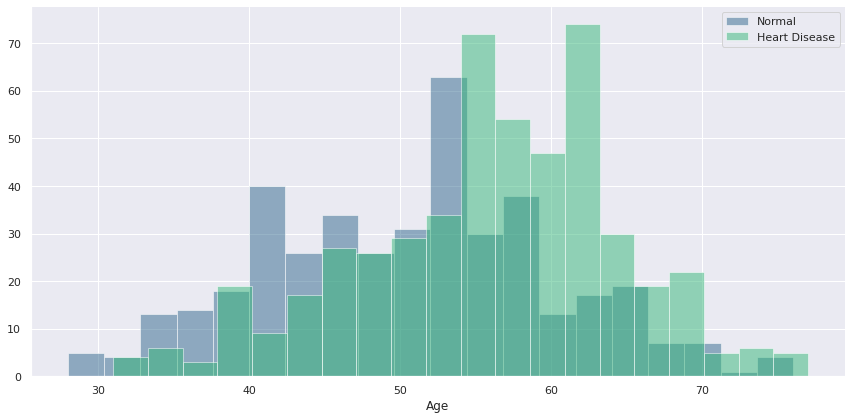

In [14]:
sns.set_style('darkgrid')
g = sns.FacetGrid(df,hue="HeartDisease",palette='viridis',height=6,aspect=2)
g = g.map(plt.hist,'Age',bins=20,alpha=0.5)
plt.legend(labels=['Normal','Heart Disease'])

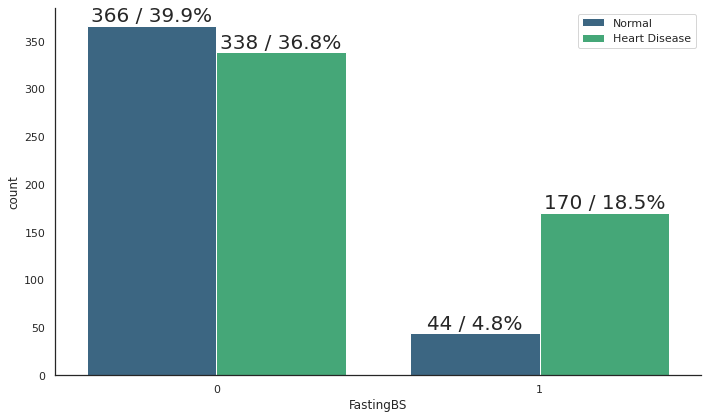

In [15]:
total_cnt = df['HeartDisease'].count()
plt.figure(figsize=(10,6))
sns.set(font_scale = 1)
sns.set_style("white")
ax = sns.countplot(data=df, x='FastingBS',hue='HeartDisease',palette='viridis')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 10, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=20)
plt.legend(labels=labels)
sns.despine()
plt.tight_layout()

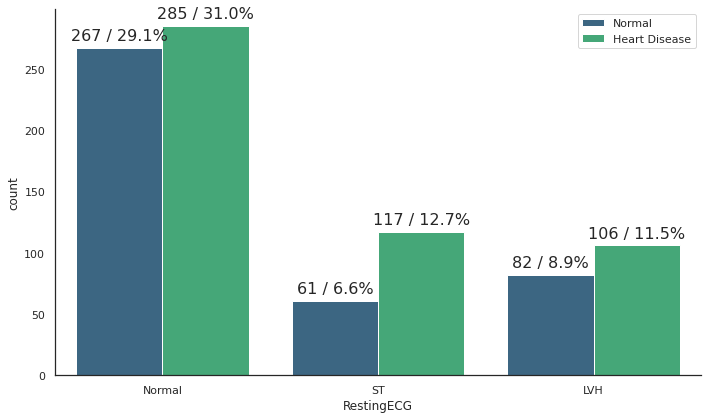

In [16]:
plt.figure(figsize=(10,6))
sns.set(font_scale = 1)
sns.set_style("white")
ax = sns.countplot(data=df, x='RestingECG',hue='HeartDisease',palette='viridis')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 10, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=16)
plt.legend(labels=labels)
sns.despine()
plt.tight_layout()

# Defining dummy variables

In [17]:
df = pd.get_dummies(df,drop_first=True)

In [18]:
df.head(5)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


# Modeling

In [19]:
heart_df = df.copy()
heart_df

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,1.2,1,1,0,0,1,1,0,0,1,0
914,68,144,193,1,141,3.4,1,1,0,0,0,1,0,0,1,0
915,57,130,131,0,115,1.2,1,1,0,0,0,1,0,1,1,0
916,57,130,236,0,174,0.0,1,0,1,0,0,0,0,0,1,0


In [20]:
X = heart_df.drop('HeartDisease',axis=1)
y = heart_df.pop('HeartDisease')

In [21]:
all_cols = [cname for cname in X.columns]
print(all_cols)

['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [23]:
scaler = StandardScaler()

In [24]:
scaler.fit(X)

StandardScaler()

In [25]:
scaled_df = scaler.fit_transform(X)

In [26]:
df_scaled = pd.DataFrame(scaled_df,columns=df.columns[:-1])
df_scaled.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat
0,-1.433140,0.410909,0.825070,-0.551341,1.382928,-0.832432,0.515952,2.075177,-0.532838,-0.229679,0.814275,-0.490449,-0.823556,-1.002181,1.150674
1,-0.478484,1.491752,-0.171961,-0.551341,0.754157,0.105664,-1.938163,-0.481887,1.876744,-0.229679,0.814275,-0.490449,-0.823556,0.997824,-0.869056
2,-1.751359,-0.129513,0.770188,-0.551341,-1.525138,-0.832432,0.515952,2.075177,-0.532838,-0.229679,-1.228087,2.038947,-0.823556,-1.002181,1.150674
3,-0.584556,0.302825,0.139040,-0.551341,-1.132156,0.574711,-1.938163,-0.481887,-0.532838,-0.229679,0.814275,-0.490449,1.214246,0.997824,-0.869056
4,0.051881,0.951331,-0.034755,-0.551341,-0.581981,-0.832432,0.515952,-0.481887,1.876744,-0.229679,0.814275,-0.490449,-0.823556,-1.002181,1.150674


In [27]:
X=df_scaled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=300)

In [28]:
logmodel = LogisticRegression()

In [29]:
logmodel.fit(X_train,y_train)

LogisticRegression()

In [30]:
preds = logmodel.predict(X_test)

In [31]:
from sklearn.metrics import confusion_matrix,classification_report

In [32]:
confusion_matrix(y_test,preds)

array([[141,  30],
       [ 17, 180]])

In [33]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.89      0.82      0.86       171
           1       0.86      0.91      0.88       197

    accuracy                           0.87       368
   macro avg       0.87      0.87      0.87       368
weighted avg       0.87      0.87      0.87       368

